# <center>Centro Universitário Facens<br/></center>
<br/>
<font size="4"><center><b>Disciplina: Processamento de imagens</b></center></font>
  
<font size="3"><center>Prof. Renato M. Silva</center></font>
<br/>
<br/>

## <center>Avaliação Continuada 2 (AC2)</center>

----
### <center>Nome e RA dos componentes do grupo</center>

    
| Nome     |      RA      | 
|:-        |:-------------:|
|          |              | 
|          |              | 
|          |              | 
|          |              | 
|          |              | 
    

----
### Instruções
**1**. Siga boas práticas de programação:
- dar nomes intuitivos para as variáveis
- dar nomes intuitivos para as funções

**2**. O trabalho pode ser feito em grupos de até 5 pessoas. Porém, todos os componentes devem ser da mesma turma de Processamento de Imagens. 
 - Caso algum grupo contenha alguém de uma turma diferente, todo o grupo receberá nota zero.
 - Apenas uma pessoa do grupo deve submeter o trabalho. 
 - Você deve submeter apenas o arquivo .ipynb.

**3**. Em todos os exercícios, as imagens finais solicitadas devem estar no formato **uint8**.

**4**. Cuidado com plágio. Se for detectado plágio entre grupos, a punição será dada para todos os componentes dos grupos envolvidos. 

**5**. Antes de submeter o notebook, certifique-se que não há erros de código. Uma forma de se certificar disso é usar a opção **"Reiniciar Kernel e executar todas as células"** do Jupyter ou a opção **"Reiniciar e executar tudo"** do Google Colab. 

**6**. A única biblioteca de processamento de imagens permitida neste trabalho é a **OpenCV**. Porém, alguns exercícios poderão limitar algumas funções dessa biblioteca que poderão ser usadas. 

**7**. Em todos os exercícios que pedirem para salvar a imagem resultante, tome cuidado de converter a imagem para BGR antes de salvá-la pois esse é o formato padrão da biblioteca OpenCV. Caso contrário, os canais de cores da imagem resultante ficarão trocados. 

**8**. Em todos os exercícios, caso o resultado seja uma ou mais imagens, você deve mostrá-las na tela. 

----
## Exercício 1

Implemente uma função que consiga fazer a detecção de movimentos em um vídeo. Ela deverá extrair os frames do vídeo e, para cada frame, deve calcular o **histograma** da imagem e compará-lo com os últimos histogramas calculados. Quando a diferença entre estes ultrapassar um limiar pré-estabelecido, simule um alarme interrompendo a função e retornando uma mensagem de alerta. Utilize uma função de comparação que julgar conveniente. 
- A diferença entre dois histogramas pode ser calculada por meio de medidas estatísticas, como média, desvio padrão, mediana, IQR, etc. 

Teste a função no vídeo *videos/cameraEscondida.mp4*.

**Obs.** Neste exercício é permitido usar a biblioteca **imageio** ou qualquer para **extrair os frames** do vídeo.

In [101]:
import numpy as np
import cv2
import sys
from time import sleep


##primeiramente será necessário esppecificar o caminho do vídeo
VIDEO_CAMINHO = 'C:/Users/Lucas/Documents/visao computacional/2023S1_AC2/videos/cameraEscondida.mp4'


w_min = 5  # largura minima do retangulo
h_min = 5  # altura minima do retangulo
offset = 2  # Erro permitido entre pixel
linha_ROI = 135  # Posição da linha de contagem
movimento = False



def centroide(x, y, w, h):
    """
    :param x: x do objeto
    :param y: y do objeto
    :param w: largura do objeto
    :param h: altura do objeto
    :return: tupla que contém as coordenadas do centro de um objeto
    """
    x1 = w // 2
    y1 = h // 2
    cx = x + x1
    cy = y + y1
    return cx, cy



def Kernel(TIPO_KERNEL):
    if TIPO_KERNEL == 'dilation':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    if TIPO_KERNEL == 'opening':
        kernel = np.ones((3,3), np.uint8)
    if TIPO_KERNEL == 'closing':
        kernel = np.ones((3, 3), np.uint8)
    return kernel



##agora será necessário definir alguns algorítmos para destacar o fundo
##para compara-los e encontrar o mais coerente para detectar omovimento

tipos_algoritmos = ['GMG', 'MOG2', 'MOG', 'KNN', 'CNT','CUSTOM']



Gx = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])
Gy = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

def Filter(img, filter):
    if filter == 'closing':
        return cv2.morphologyEx(img, cv2.MORPH_CLOSE, Kernel('closing'), iterations=2)
    if filter == 'opening':
        return cv2.morphologyEx(img, cv2.MORPH_OPEN, Kernel('opening'), iterations=2)
    if filter == 'dilation':
        return cv2.dilate(img, Kernel('dilation'), iterations=2)
    if filter == 'combine':
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, Kernel('closing'), iterations=2)
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, Kernel('opening'), iterations=2)
        dilation = cv2.dilate(opening, Kernel('dilation'), iterations=2)
        return dilation


def Subtractor(tipos_algoritmos):
    if tipos_algoritmos == 'GMG':
        return cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames = 120, 
                                                        decisionThreshold=0.8)
    if tipos_algoritmos == 'MOG':
        return cv2.bgsegm.createBackgroundSubtractorMOG(history = 100, nmixtures = 5,
                                                        backgroundRatio = 0.7, 
                                                        noiseSigma = 0)
    if tipos_algoritmos == 'MOG2':
        return cv2.createBackgroundSubtractorMOG2(history = 500, detectShadows=True,
                                                varThreshold=100)
    if tipos_algoritmos == 'KNN':
        return cv2.createBackgroundSubtractorKNN(history=500, dist2Threshold=400, 
                                                 detectShadows=True)
    if tipos_algoritmos == 'CNT':
        return cv2.bgsegm.createBackgroundSubtractorCNT(minPixelStability=15, 
                                                        useHistory =True,
                                                        maxPixelStability=15*60,
                                                        isParallel=True)

 
 
     
    print('Detector inválido')
    sys.exit(1)
    
def Sobel(video,Gx,Gy):
    imgGx = cv2.filter2D(video, ddepth=-1, kernel = Gx)
    imgGy = cv2.filter2D(video, ddepth=-1, kernel = Gy) 
    ##imgTrat =  (imgGy** imgGy + imgGx **imgGx)**(1/2)
    imgTrat =  np.maximum(np.abs(imgGx),np.abs(imgGy))
    
    
    ##aplicando um limiar
    limiarT = 220
    mascara = (
    (imgTrat [:,:,0]<limiarT) &
    (imgTrat [:,:,1]<limiarT) &
    (imgTrat [:,:,2]<limiarT ))
    
    imgFinal =  imgTrat.copy()
    
    mascara =   imgTrat > limiarT
    imgFinal [ mascara ] = 255
    
    mascara =   imgTrat < limiarT
    imgFinal [ mascara ] = 0  
    
    
    
    return imgFinal 

   
w_min = 5  # largura minima do retangulo
h_min = 5  # altura minima do retangulo
offset = 2  # Erro permitido entre pixel
linha_ROI = 135  # Posição da linha de contagem
movimento = False
cap = cv2.VideoCapture(VIDEO_CAMINHO)



def set_info(detec):
    global movimento
    for (x, y) in detec:
        if (linha_ROI + offset) > y > (linha_ROI - offset):
            movimento = True
            cv2.line(frame, (0, linha_ROI), (1200, linha_ROI), (0, 127, 255), 3)
            detec.remove((x, y))
            print("Movimento detectado: " + str(movimento))


detec = []
def set_info(detec):
    global movimento
    for (x, y) in detec:
        if (linha_ROI + offset) > y > (linha_ROI - offset):
            movimento = True
            cv2.line(frame, (0, linha_ROI), (1200, linha_ROI), (0, 127, 255), 3)
            detec.remove((x, y))
            print("Movimento detectado: " + str(movimento))

def mostra_video(mask, video,sobel):
    
    cv2.imshow("mascara", mask)
    cv2.imshow("original", video)
    cv2.imshow("sobel", sobel)

    
tipos_algoritmos = 'GMG'
subtrator_de_fundo = Subtractor(tipos_algoritmos)   




       
while True:

    hasFrame, frame = cap.read() # Pega cada frame do vídeo

    if not hasFrame:
        break



    mask = subtrator_de_fundo.apply(frame)
    mask = Filter(mask, 'combine')
    IMGsobel = Sobel(frame,Gx,Gy) 
    contorno, img = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.line(frame, (25, linha_ROI), (1200, linha_ROI), (255, 127, 0), 3)
    for (i, c) in enumerate(contorno):
        (x, y, w, h) = cv2.boundingRect(c)
        validar_contorno = (w >= w_min) and (h >= h_min)
        if not validar_contorno:
            continue

        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        centro = centroide(x, y, w, h)
        detec.append(centro)
        cv2.circle(frame, centro, 4, (0, 0, 255), -1)

    set_info(detec)
    
    mostra_video(mask,frame,IMGsobel)
    
    if cv2.waitKey(1) == 27: #ESC
        break

cv2.destroyAllWindows()
cap.release()

----
## Exercício 2


Implemente um algoritmo que faça a combinação das imagens **figs/facensLogo.png** e **facensVistaAerea.webp** para gerar o resultado apresentado abaixo. Salve a imagem resultante na pasta **figsResultado** com o nome **ex02.png**

Para atingir esse resultado, as únicas funções da biblioteca **OpencCV** que poderão ser aplicadas são: **warpAffine**, **getRotationMatrix2D**, **resize**, **cvtColor** e aquelas que sirvam para abrir ou salvar uma imagem. Todas as demais operações deverão ser implementadas por meio de operações matriciais, podendo ser aplicadas função da biblioteca **NumPy**. 

**Dicas**: 
- Divida a imagem **facensVistaAerea.webp** em quatro partes iguais. Depois disso, aplique rotação em cada uma das 4 partes.
- Para remover o fundo da imagem **figs/facensLogo.png**, você pode usar a segmentação por limiarização. Depois disso, você pode rotacionar cada uma dos quatro quadrantes para conseguir atingir o efeito mostrado na imagem abaixo.
- Você pode usar as operações de soma e de escalamento para ajudar a atingir a imagem alvo.

<center>
<div style="display:inline-block;">
    <div style="padding: 5px; float: left;">
        <img src="figsNotebook/facens1.jpg" width="400" height="400" />
    </div>
</div> 
</center>

(520, 924, 4)


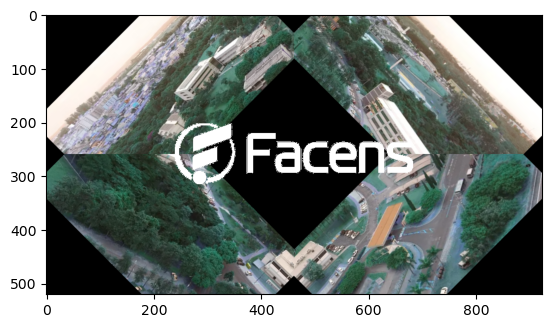

True

In [102]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
CAMINHO_VISTA= './figs/facensVistaAerea.webp'
img2 = cv2.imread(CAMINHO_VISTA, cv2.IMREAD_UNCHANGED)
rgba_vista = cv2.cvtColor(img2, cv2.COLOR_BGR2RGBA)


altura, largura = rgba_vista.shape[:2]

meia_altura = altura // 2
meia_largura = largura // 2


cima_esquerda = rgba_vista[0:meia_altura, 0:meia_largura]
cima_direita = rgba_vista[0:meia_altura, meia_largura:largura]
baixo_esquerda = rgba_vista[meia_altura:altura, 0:meia_largura]
baixo_direita = rgba_vista[meia_altura:altura, meia_largura:largura]


angulo_positivo = 45
angulo_negativo = -45


M_positivo = cv2.getRotationMatrix2D((meia_largura/2, meia_altura/2), angulo_positivo, 1)
M_negativo = cv2.getRotationMatrix2D((meia_largura/2, meia_altura/2), angulo_negativo, 1)
cima_esquerda_rotacionada = cv2.warpAffine(cima_esquerda, M_positivo, (meia_largura, meia_altura))
cima_direita_rotacionada = cv2.warpAffine(cima_direita, M_negativo, (meia_largura, meia_altura))
baixo_esquerda_rotacionada = cv2.warpAffine(baixo_esquerda, M_negativo, (meia_largura, meia_altura))
baixo_direita_rotacionada = cv2.warpAffine(baixo_direita, M_positivo, (meia_largura, meia_altura))


resultado_cima = np.concatenate((cima_esquerda_rotacionada, cima_direita_rotacionada), axis=1)
resultado_baixo = np.concatenate((baixo_esquerda_rotacionada, baixo_direita_rotacionada), axis=1)
resultado = np.concatenate((resultado_cima, resultado_baixo), axis=0)
print(resultado.shape)






CAMINHO_LOGO = './figs/facensLogo.png'
img = cv2.imread(CAMINHO_LOGO, cv2.IMREAD_UNCHANGED)
rgba_logo = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
rgb_channels = rgba_logo[:, :, :3]
alpha_channel = rgba_logo[:, :, 3]
white_pixels_mask = np.all(rgb_channels == [255, 255, 255], axis=2)
alpha_channel[white_pixels_mask] = 0
rgba_logo[:, :, 3] = alpha_channel

nova_altura=520
nova_largura = 924
altura_quadrante = rgba_vista.shape[0] // 2
largura_quadrante = rgba_vista.shape[1] // 2


M1 = cv2.getRotationMatrix2D((largura_quadrante, altura_quadrante), 45, 0.5)
quadrante1_rotacionado = cv2.warpAffine(rgba_vista[:altura_quadrante, :largura_quadrante], M1, (largura_quadrante, altura_quadrante))
quadrante1_redimensionado = cv2.resize(quadrante1_rotacionado, (largura_quadrante, altura_quadrante))
M2 = cv2.getRotationMatrix2D((largura_quadrante, altura_quadrante), -45, 1.0)
quadrante2_rotacionado = cv2.warpAffine(rgba_vista[:altura_quadrante, largura_quadrante:], M2, (largura_quadrante, altura_quadrante))
quadrante2_redimensionado = cv2.resize(quadrante2_rotacionado, (largura_quadrante, altura_quadrante))
quadrante3_rotacionado = cv2.warpAffine(rgba_vista[altura_quadrante:, :largura_quadrante], M2, (largura_quadrante, altura_quadrante))
quadrante3_redimensionado = cv2.resize(quadrante3_rotacionado, (largura_quadrante, altura_quadrante))

# Rotaciona e redimensiona o quadrante 4
quadrante4_rotacionado = cv2.warpAffine(rgba_vista[altura_quadrante:, largura_quadrante:], M1, (largura_quadrante, altura_quadrante))
quadrante4_redimensionado = cv2.resize(quadrante4_rotacionado, (largura_quadrante, altura_quadrante))


nova_imagem_final = np.zeros_like(rgba_vista)
nova_imagem_final[:altura_quadrante, :largura_quadrante] = quadrante1_redimensionado
nova_imagem_final[:altura_quadrante, largura_quadrante:] = quadrante2_redimensionado
nova_imagem_final[altura_quadrante:, :largura_quadrante] = quadrante3_redimensionado
nova_imagem_final[altura_quadrante:, largura_quadrante:] = quadrante4_redimensionado

nova_imagem = np.zeros((nova_altura, nova_largura, 4), dtype=np.uint8)
x = (nova_largura - rgba_logo.shape[1]) // 2
y = (nova_altura - rgba_logo.shape[0]) // 2
nova_imagem[y:y+rgba_logo.shape[0], x:x+rgba_logo.shape[1]] = rgba_logo


mask = nova_imagem[..., 3] > 0
nova_imagem[mask] = [255, 255, 255, 255]





mask = nova_imagem[..., 3] > 0
resultado[mask] = nova_imagem[mask]


resultadoFinal =  cv2.cvtColor(resultado, cv2.COLOR_RGBA2BGR)
plt.imshow(resultadoFinal)
plt.show()
cv2.imwrite('figsResultado/ex02.png', resultadoFinal)

----
## Exercicio 3

Implemente uma função que receba uma imagem e retorne três imagens novas: uma contendo apenas os objetos com cor predominantemente vermelhas, outro com os objetos que possuem cor predominantemente verde e uma com os objetos com cor predominantemente azuis. Os demais objetos devem desaparecer da imagem resultante, transformando seus pixels para o valor 0. 

Para atingir o objetivo deste exercício é permitido usar apenas a biblioteca NumPy. As únicas funções da biblioteca OpenCV permitidas são a **cvtColor** e aquelas que abrem ou salvam uma imagem. 

Teste sua função passando como entrada a imagem **figs/objetos.png**. Salve as imagens resultantes na pasta "**figsResultado**" com os seguintes nomes: **ex03_objetosVermelhos.png**, **ex03_objetosVerdes.png** e **ex03_objetosAzuis.png**.

Dicas: 

 - Usando a biblioteca Numpy, é possível selecionar apenas os valores de uma determinada matriz que atendem a mais de uma restrição. Por exemplo, supondo que você queira transformar os valores de uma matriz que sejam maiores que 50 e menores que 100 para -1, você poderia aplicar a seguinte operação:

```matriz[ (matriz>50) & (matriz<100) ] = -1 ```

----
## Exercicio 4


Faça uma função que desenhe um rosto. Essa função deve receber como parâmetro a cor do rosto, dos olhos, do nariz e da boca. 

A função deve funcionar para todas as cores primárias, secundárias e, também, preto e branco. No entanto, só é permitido criar os objetos que formam o rosto com as cores primárias. Para gerar objetos com preto, branco e cores secundárias, você deverá fazer operações aritméticas usando objetos gerados com as cores primárias. 

Por exemplo, supondo que essa função tenha recebido rosto="preto", olhos="vermelho", nariz="branco", boca="verde" como entrada, ela deveria produzir o rosto similar ao mostrado abaixo. 

-  Neste exercício é permitido usar apenas a biblioteca NumPy. As únicas funções da biblioteca OpenCV permitidas são a **cvtColor** e aquelas que abrem ou salvam uma imagem. 

- A imagem resultante não precisa ser igual a mostrada no exemplo. Pode exercer sua criatividade, desde que o rosto, olhos, boca e nariz sejam criados por meio de operações matriciais.

- Teste sua função com três entradas diferentes e salve as imagens na pasta **figsResultado** com os nomes: ex04_rosto1.png, ex04_rosto2.png, ex04_rosto3.png


<center>
<div style="display:inline-block;">
    <div style="padding: 5px; float: left;">
        <img src="figsNotebook/rosto.png" width="150" height="150" />
    </div>
</div> 
</center>

In [103]:
import numpy as np
import cv2

def gera_rosto(cor_rosto, cor_olhos, cor_boca, cor_nariz):
    linhas = 500
    colunas = 550
    rosto = np.zeros((linhas, colunas, 3), dtype=np.uint8)
    rosto[:, :] = cor_rosto

    tamanho_olhos = 20
    olhos = np.array(cor_olhos, dtype=np.uint8)

    altura, largura, _ = rosto.shape

    tamanho_olho = altura // 10
    x_esquerdo = largura // 2 - tamanho_olho - 100
    y_esquerdo = altura // 2 - tamanho_olho * 3
    x_direito = largura // 2 + 100
    y_direito = altura // 2 - tamanho_olho * 3

    rosto[y_esquerdo:y_esquerdo+tamanho_olho, x_esquerdo:x_esquerdo+tamanho_olho] = olhos
    rosto[y_direito:y_direito+tamanho_olho, x_direito:x_direito+tamanho_olho] = olhos

    largura_boca = largura // 3
    altura_boca = altura // 10
    x_boca = largura // 2 - largura_boca // 2
    y_boca = altura // 2 + altura // 5

    rosto[y_boca:y_boca+altura_boca, x_boca:x_boca+largura_boca] = cor_boca

    largura_nariz = largura // 12
    altura_nariz = altura // 5
    x_nariz = largura // 2 - largura_nariz // 2
    y_nariz = altura // 2 - altura_nariz // 2

    rosto[y_nariz:y_nariz+altura_nariz, x_nariz:x_nariz+largura_nariz] = cor_nariz

    return rosto


cores = {
    'vermelho': np.array([0, 0, 255], dtype=np.uint8),
    'azul': np.array([255, 0, 0], dtype=np.uint8),
    'amarelo': np.array([0, 255, 255], dtype=np.uint8),
    'verde': np.array([0, 255, 0], dtype=np.uint8),
    'laranja': np.array([0, 165, 255], dtype=np.uint8),
    'roxo': np.array([128, 0, 128], dtype=np.uint8),
    'branco': np.array([255, 255, 255], dtype=np.uint8),
    'preto': np.array([0, 0, 0], dtype=np.uint8)
}

contador = 1

while True:
 
    cor_rosto = input("Digite a cor do rosto (vermelho, azul, amarelo, verde, laranja, roxo, branco, preto): ").lower()
    cor_olhos = input("Digite a cor dos olhos (vermelho, azul, amarelo, verde, laranja, roxo, branco, preto): ").lower()
    cor_boca = input("Digite a cor da boca (vermelho, azul, amarelo, verde, laranja, roxo, branco, preto): ").lower()
    cor_nariz = input("Digite a cor do nariz (vermelho, azul, amarelo, verde, laranja, roxo, branco, preto): ").lower()


    if cor_rosto not in cores or cor_olhos not in cores or cor_boca not in cores or cor_nariz not in cores:
        print("Cores inválidas. Tente novamente.")
        continue

    rosto = gera_rosto(cores[cor_rosto], cores[cor_olhos], cores[cor_boca], cores[cor_nariz])


    if rosto is None:
        print("Erro ao gerar o rosto. Tente novamente.")
        continue


    nome_arquivo = f"ex04_rosto{contador}.png"
    cv2.imwrite(f"C:/Users/Lucas/Documents/visao computacional/2023S1_AC2/AC2/figsResultado/{nome_arquivo}", rosto)

    contador += 1


    continuar = input("Deseja criar outro rosto? (s/n): ")
    if continuar.lower() == 'n':
        break

print("Rostos salvos com sucesso!")

----
## Exercicio 5

Utilize operações morfológicas nas imagens **figs/manequim.png** e **figs/tabuleiro.jpg** para remover todos os pontos brancos. Por outro lado, use as operaçòes morfológicas para remover apenas os círculos menores da imagem **figs/circulos.tif**, deixando apenas os círculos maiores. 


Salve as imagens resultantes na pasta **figsResultado** com os nomes ex05_manequim.png, ex05_tabuleiro.png e ex05_circulos.png.

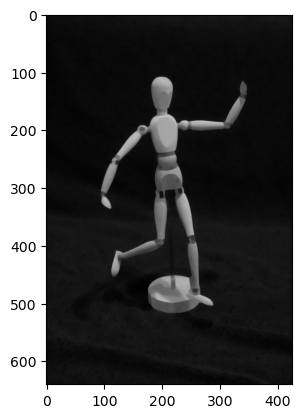

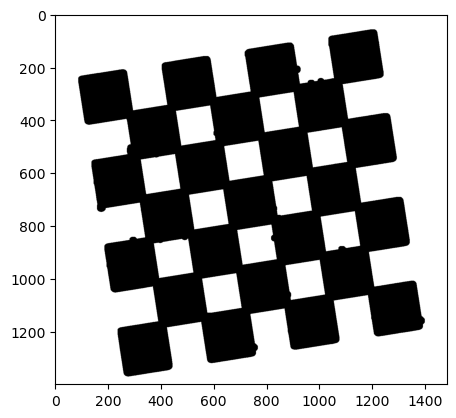

True

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

manequim = cv2.imread('figs/manequim.png')
tabuleiro = cv2.imread('figs/tabuleiro.png')
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
ellipse2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))

manequimProcessado = cv2.dilate(manequim,ellipse)
manequimProcessado = cv2.erode(manequim,ellipse)


tabuleiroProcessado = cv2.dilate(tabuleiro,ellipse)
tabuleiroProcessado = cv2.erode(tabuleiro,ellipse2)
tabuleiroProcessado = cv2.erode(tabuleiro,ellipse2)





plt.imshow(manequimProcessado)
plt.show()

cv2.imwrite(f"C:/Users/Lucas/Documents/visao computacional/2023S1_AC2/AC2/figsResultado/ex05_manequim.png", manequimProcessado)


plt.imshow(tabuleiroProcessado)
plt.show()
cv2.imwrite(f"C:/Users/Lucas/Documents/visao computacional/2023S1_AC2/AC2/figsResultado/ex05_tabuleiro.png", tabuleiroProcessado)


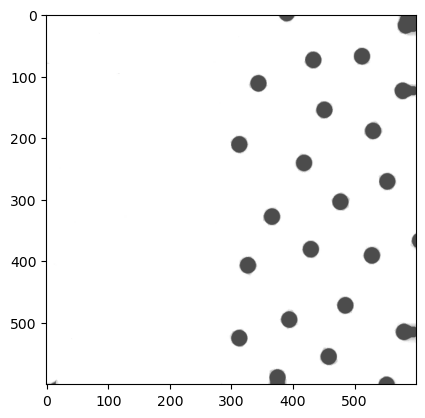

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carregar a imagem .tif
imagem = cv2.imread('figs/circulos.tif', cv2.IMREAD_UNCHANGED)

# Verificar se a imagem foi carregada corretamente
if imagem is None:
    print("Erro ao carregar a imagem.")
    exit()

# Converter imagem RGBA para RGB
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGRA2BGR)



ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
ellipse2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(45,45))

imagem_rgbprocessada = cv2.dilate(imagem_rgb,ellipse2)

plt.imshow(imagem_rgbprocessada)
plt.show()


cv2.imwrite(f"C:/Users/Lucas/Documents/visao computacional/2023S1_AC2/AC2/figsResultado/ex05_circulos.png", imagem_rgbprocessada)

----
## Exercicio 6

Aplique um filtro para borrar as extremidades da imagem **figs/vista.jpg** para que ela fique com o efeito mostrado na imagem abaixo. Salve a imagem resultante na pasta **figsResultado** com o nome **ex06_vista.png**

<img src="figsNotebook/vista_blur.jpg" width="500" height="128" />

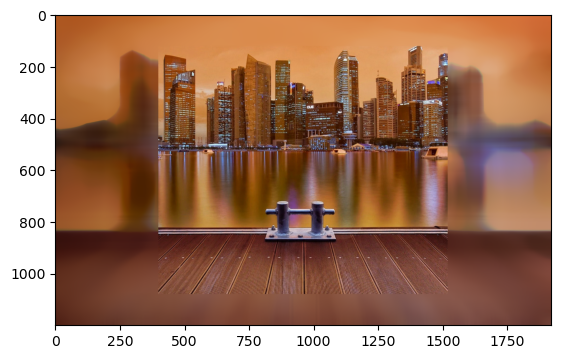

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carregar a imagem
imagem = cv2.imread('figs/vista.jpg')

# Converter a imagem para RGBA
imagem_RGBA = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGBA)

imagem_RGBABORRADA = imagem_RGBA.copy()
imagem_cinza = cv2.cvtColor(imagem_RGBA, cv2.COLOR_RGBA2GRAY)
# Definir a primeira faixa desejada no canal alfa
altura, largura, _ = imagem_RGBA.shape
faixa_inicio = 0
faixa_fim = 400
imagem_RGBA[:, faixa_inicio:faixa_fim, 3] = 1

# Definir a segunda faixa desejada no canal alfa
faixa_inicio2 =  -400
faixa_fim2 = largura
imagem_RGBA[:, faixa_inicio2:faixa_fim2, 3] = 1



faixa_inicio3 = 0
faixa_fim3 = altura // 10
imagem_RGBA[faixa_inicio3:faixa_fim3, :, 3] = 1

# Definir a faixa inferior desejada no canal alfa
faixa_inicio4 = altura - altura // 10
faixa_fim4 = altura
imagem_RGBA[faixa_inicio4:faixa_fim4, :, 3] = 1
imagem_RGBABORRADA = cv2.medianBlur(imagem_RGBABORRADA, 101)




mascara = imagem_RGBA[:, :, 3] == 1

imagem_RGBA[mascara] = imagem_RGBABORRADA[mascara]

imagemResult = cv2.cvtColor(imagem_RGBA, cv2.COLOR_RGBA2BGR)
# Exibir a imagem resultante
plt.imshow(imagemResult)
plt.show()

cv2.imwrite(f"C:/Users/Lucas/Documents/visao computacional/2023S1_AC2/AC2/figsResultado/ex06_vista.png", imagemResult)


----
## Exercicio 7

Sabe-se que as técnicas de filtragem podem ser usadas para eliminar ruídos. Porém, elas também podem perder detalhes da imagem. Uma forma de diminuir o problema da perda de detalhes é aplicar um realce na imagem após a filtragem. 

Sabe-se também que é possível aplicar realce combinando a imagem filtrada com a o resultado da sua detecção de bordas. 

Com base nas afirmações acima, aplique pelo menos dois filtros na imagem **figs/lena_noise.png** para diminuir o ruído. Depois, para aumentar o realce, faça uma operação aritmética de cada uma das imagens filtradas com o resultado da detecção de bordas por meio do operador de gradiente de Robinson (1977) e outras duas técnicas de detecção de bordas quaisquer. Salve as imagens resultantes na pasta **figsResultado** com os nomes: "ex07_filtro1borda1.png", "ex07_filtro2borda1.png", "ex07_filtro1borda2.png", "ex07_filtro2borda2.png"  "ex07_filtro3borda1.png", "ex07_filtro3borda2.png".

 - trate os tons de cinza inválidos usando a técnica de saturação

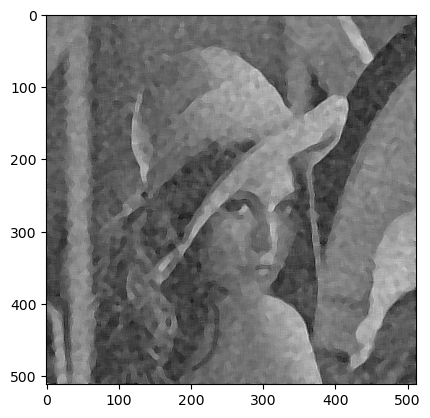

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

CAMINHO_IMAGEM ='figs/lena_noise.png' 



imagem = cv2.imread(CAMINHO_IMAGEM)
imagem_filtrada = cv2.blur(imagem, (5, 5))
imagem_filtrada2 = cv2.medianBlur(imagem_filtrada, 9)


kernel1 = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])

Realce = cv2.filter2D(imagem_filtrada2, ddepth= -1,kernel = kernel1)

plt.imshow(Realce)

plt.show()

----
## Exercicio 8

Sabe-se que as técnicas de filtragem podem ser usadas para eliminar ruídos. Porém, elas também podem perder detalhes da imagem. Uma forma de diminuir o problema da perda de detalhes é aplicar um realce na imagem após a filtragem. 

Repita os códigos que você fez no exercício anterior para filtragem da imagem **figs/lena_noise.png**. Use as duas imagens resultantes como entrada de duas funções. A primeira deve fazer o realce combinando as técnicas de top-hat e bottom-hat. A segunda deve fazer o realce usando a seginte equação:
    
\$$g = 
\begin{cases}
f \ominus b \text{, } & \text{ se } f - (f \ominus b) <  ( f \oplus b ) - f \\
f \oplus b\text{, } & \text{ caso contrário }
\end{cases}
$$

Na equação acima,  $f \ominus b$ é o resultado da operação de erosão no pixel $f$ usando o elemento estruturante $b$. Por outro lado, $f \oplus b$ é o resultado da operação de dilatação no pixel $f$ usando o elemento estruturante $b$.

Salve as imagens resultantes na pasta **figsResultado** com os nomes: "ex08_filtro1morfologia1.png", "ex08_filtro2morfologia1.png", "ex08_filtro1morfologia2.png", "ex08_filtro2morfologia2.png".
  

----
## Exercicio 9

Por meio das técnicas aprendidas na disciplina, tente melhorar o **máximo** possível a imagem **figs/lena_pontilhada.png**. Salve a imagem resultante na pasta **figsResultado** com o nome **ex09.png**

----
## Exercício 10

Crie duas funções chamadas **esteg** e **decodificaEsteg**. A primeira função deve implementar uma técnica de esteganografia que consiste em camuflar uma mensagem em uma imagem. A segunda função deve decodificar a imagem gerada pela primeira.

A função **esteg** deve receber uma determinada imagem de entrada e uma string. Você deverá criar uma cópia da imagem passada como entrada e deverá gravar a string nela de forma que ela fique imperceptível, mesmo com zoom na imagem.

- Uma forma de atingir esse objetivo é escrever a string em uma imagem nova auxiliar. Depois usar limiarização para transformar os tons de cinza dela. Por fim, você pode usar uma operação aritmética para adicionar essa nova imagem na imagem passada como parâmetro da função.

- Você pode usar a função **putText** da biblioteca OpenCV para escrever uma string em uma imagem.

- Você pode considerar como premissa aumentar ou diminuir um único tom de cinza em alguns pixels de uma imagem qualquer irá gerar uma alteração visualmente imperceptível. 


A função **decodificaEsteg** deve receber duas imagem. A primeira delas é uma imagem que contém uma mensagem escondida. A segunda imagem é a original antes da operação de esteganografia. A função deve retornar uma nova imagem que torne visível a mensagem camuflada possibilitante a leitura dela.

 - Uma operação aritmética pode ser usada para extrair a imagem escondida
 - A limiarização pode ser usada para transformar os tons de cinza da mensagem escondida em um tom de cinza desejado para facilitar a visualização.
 
Use a função **esteg** para esconder a string dentro da imagem **facens2.jpg**, mostre a imagem resultante na tela e salve na pasta **figsResultado** com o nome **ex10_esteganografia.png**

Use a função **decodificaEsteg** para revelar a mensagem contida dentro da imagem retornada pela primeira função. Mostre a imagem resultante na tela e salve na pasta **figsResultado** com o nome **ex10_mesgDecodificada.png**.

Obs: as funções acima devem ser genéricas, ou seja, devem funcionar para quaisquer imagens passadas como entrada.